 <img src="../assets/logo.png" width=300 style="float" align="center">

---

# Using FB Prophet for Time Series Forecasting

---

**Context:** In February 2017, Facebook open-sourced its forecasting package called `Prophet`, which is meant to address some of the issues that come up when using time series data to make predictions in a business context. The model is designed to handle data with multiple seasonality and can be adjusted to account for linear or non-linear growth. One of the driving principles of the project is the "analyst-in-the-loop" framework - the idea that an analyst who has insights into the business context of the data should have a model that is intuitive to tune, without being an expert in the underlying math of time series (which is really hard!). 

This notebook will walk through some examples to demonstrate the basic workflow and functionality of the `Prophet` package. Since `Prophet` is based on `sklearn`'s API, the basic steps should be very familiar. The real value, however, is in looking under the hood and discovering what parameters you have control over. We'll go through some examples of 'well-behaved' data and (time permitting) test out some pathological examples.

**Note on sources used:** I have included links to datasets used in smaller examples throughout, but I relied heavily on Prophet's [documentation](https://facebook.github.io/prophet/) case study throughout. The code for the larger case study using the Peyton Manning dataset is adapted and in some cases (noted in comments) taken directly from the documentation. The original source of the mathematical formulas is Prophet's working [paper](https://peerj.com/preprints/3190/) by Sean J. Taylor and Benjamin Letham.

*Author: Matthew Garton*

## The Model
Decomposable model with three main components: trend, seasonality, and holidays.

$$ {\Large y(t) = g(t) + s(t) + h(t) + \varepsilon_t} $$


See the bottom of this notebook for a more detailed mathematical breakdown of the model. For a full explanation, read [the paper](https://peerj.com/preprints/3190/).

## Analyst-in-the-Loop Modeling


<img src="../assets/analyst_loop.png" width=400 style="float" align="center">

Image source: Prophet Paper (Taylor and Letham, 2017)


Areas where the analyst can adjust the model to apply their domain knowledge without necessarily being well-versed in the underlying math:

* Capacities
* Changepoints
* Holidays and seasonality
* Smoothing Parameters

In [1]:
import fbprophet
print(fbprophet.__version__)

0.6


In [2]:
# import necessary packages
import pandas as pd
from fbprophet import Prophet
#from holidays import WEEKEND, HolidayBase, easter, rd

In [4]:
# import data - notice the format of the df
manning = pd.read_csv('./data/peyton_manning.csv')
manning.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [5]:
# Prophet follows sklearn's API so the steps are the same
manning_model = Prophet() # instantiate a new Prophet model
manning_model.fit(manning); # fit the model to the data

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/danielmsheehan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [6]:
# Make a dataframe to hold your future predictions
manning_future = manning_model.make_future_dataframe(periods=365) # make a df for the future
manning_future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

In [7]:
# Use your model to 'populate' the future df with predictions
manning_forecast = manning_model.predict(manning_future)
manning_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.206497    7.441933    8.921185
3266 2017-01-16  8.531523    7.734793    9.248456
3267 2017-01-17  8.318930    7.581577    9.052760
3268 2017-01-18  8.151543    7.446054    8.890439
3269 2017-01-19  8.163477    7.420833    8.824245

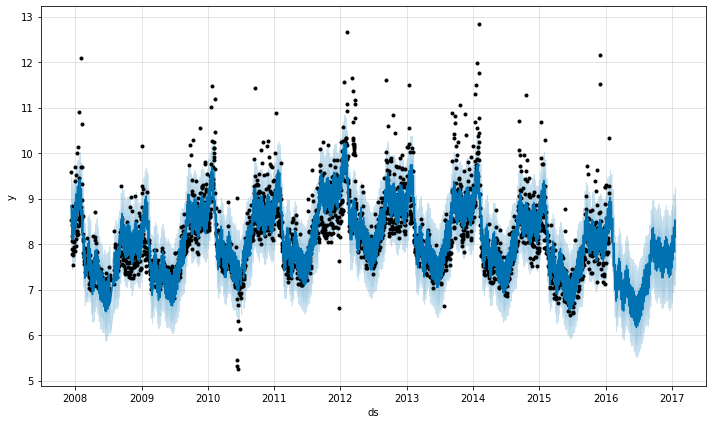

In [8]:
# plot the forecast
fig1 = manning_model.plot(manning_forecast)

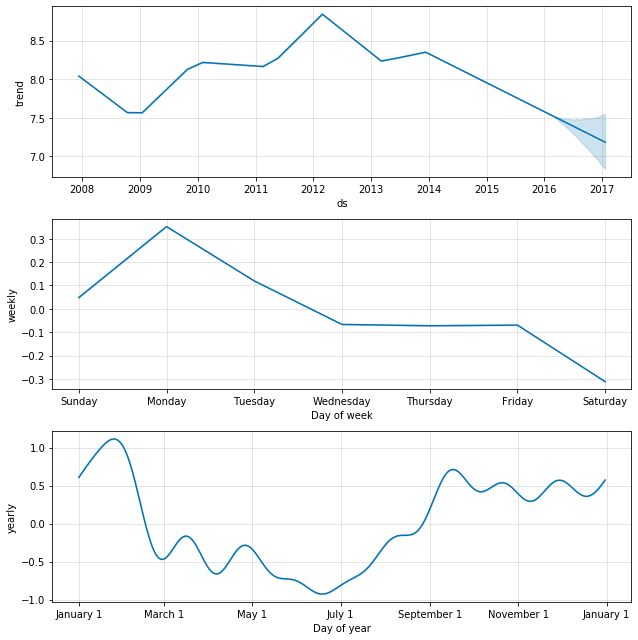

In [9]:
# plot the components of the forecast
fig2 = manning_model.plot_components(manning_forecast)

In [10]:
# make an interactive plot using plotly - code from FB Prophet Documentation
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(manning_model, manning_forecast) # this returns a plotly figure
py.iplot(fig)

## Capacities

**Capacity:** Refers to the upper and lower bound of the time series value. A simple example is market saturation - if you are trying to model how many users will adopt a product in a given market, the size of the user population serves as an upper bound (the number of facebook users is limited to the global population, for example). Subject matter expertise is generally required to set appropriate upper and lower bounds. To illustrate the effects of tuning this parameter, I will use a new dataset of monthly car sale - you'll see how forecasts yield very different results under assumptions of linear trend growth and logistic growth with carrying capacity, respectively.

Note: The capacity (upper or lower bound) can change over time - in the above example, think about population growth - so the capacity constraits are set for each row (timestamp) rather than being set as model parameters.

Source for car sales data: https://github.com/jbrownlee/Datasets

In [11]:
# Import car sales data in the correct format
car_sales = pd.read_csv('./data/monthly-car-sales.csv',
                  header=0, names=['ds','y'])

# Set a capacity (upper bound) for the series
car_sales['cap'] = 25000

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


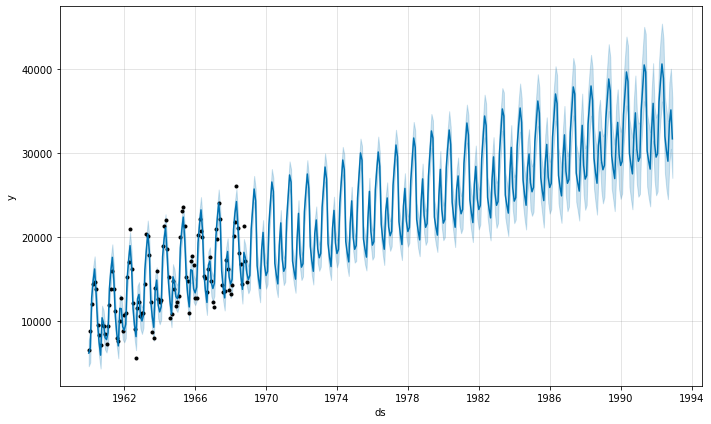

In [12]:
# For comparison, here is the default behavior - linear growth with no cap
car_sales_model = Prophet(growth='linear')
car_sales_model.fit(car_sales)

future_car_sales = car_sales_model.make_future_dataframe(periods=288, freq='M')
car_sales_forecast = car_sales_model.predict(future_car_sales) 

fig1 = car_sales_model.plot(car_sales_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


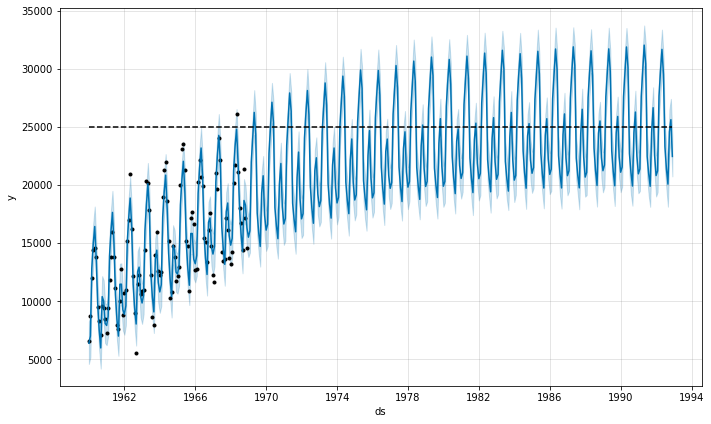

In [13]:
# The logistic growth model requires a cap
car_sales_model = Prophet(growth='logistic')
car_sales_model.fit(car_sales)

future_car_sales = car_sales_model.make_future_dataframe(periods=288, freq='M')
future_car_sales['cap'] = 25000
car_sales_forecast = car_sales_model.predict(future_car_sales) 

fig1 = car_sales_model.plot(car_sales_forecast)

## Changepoints

**Changepoint**: A point at which the trend of a time series abruptly changes.

Prophet's default behaviour is to detect changepoints automatically. It starts by allowing for a large number of *potential changepoints* and then using as few of them as possible. Mathematically, the way the model goes from potential changepoints to actual changepoints is analogous to how Lasso regularization reduces the number of features in a model. For this illustration, I'll return to the dataset facebook uses in its documentation - the Peyton Manning dataset.

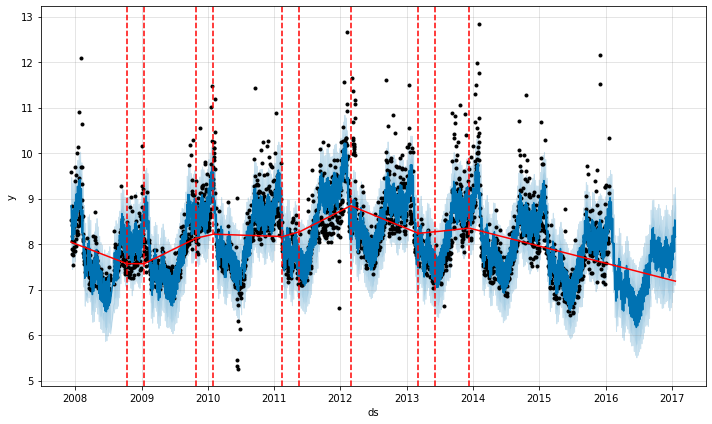

In [14]:
# example demonstrating automatic changepoints
from fbprophet.plot import add_changepoints_to_plot
fig = manning_model.plot(manning_forecast)
a = add_changepoints_to_plot(fig.gca(), manning_model, manning_forecast)

### Trend Flexibility

### User Defined Changepoints

* Manually specify points where you think the trend *could* change.
* Can be added to the automatically generated vector, or entirely user-defined.
* The behaviour is the same as for Lasso --> sparse regularization

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


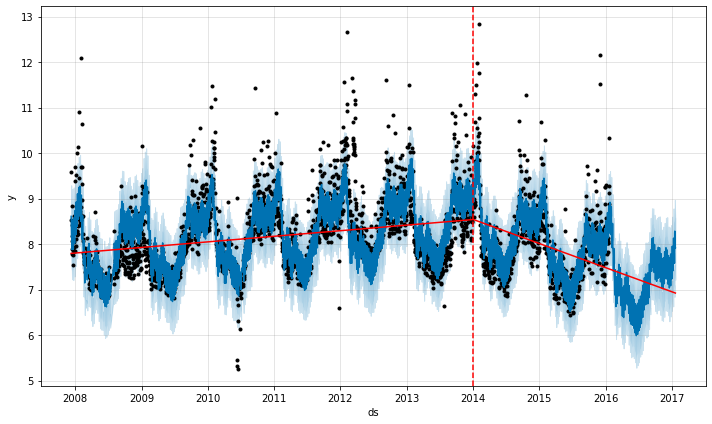

In [15]:
# user defined changepoints
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(manning).predict(manning_future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Seasonality and Holidays

In [16]:
# Adding in 'playoffs' - code from FB's documentation

playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                          '2010-01-24', '2010-02-07', '2011-01-08',
                          '2013-01-12', '2014-01-12', '2014-01-19',
                          '2014-02-02', '2015-01-11', '2016-01-17',
                          '2016-01-24', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1    
})

superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-12', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1
})

holidays = pd.concat((playoffs, superbowls))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


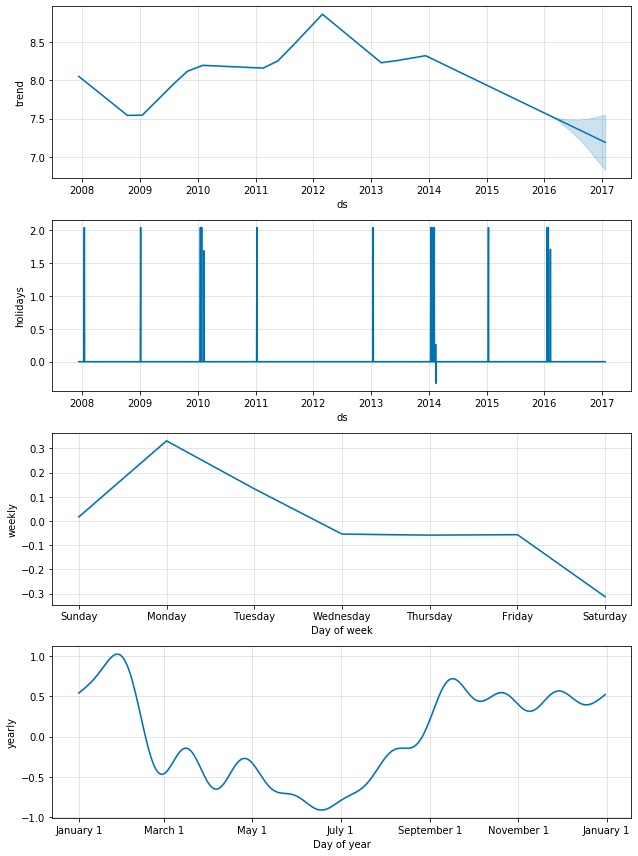

In [17]:
m = Prophet(holidays=holidays)
forecast = m.fit(manning).predict(manning_future)

fig = m.plot_components(forecast)

## Seasonality

Estimated using a partial Fourier sum, where the number of terms in the sum (the order of the series) is a parameter that determines how quickly the seasonality can change.

#### Resources on Fourier Series

* [3Blue1Brown Video](https://www.youtube.com/watch?v=r6sGWTCMz2k)
* [Brilliant.org Wiki](https://brilliant.org/wiki/fourier-series/)
* [Wikipedia Page](https://en.wikipedia.org/wiki/Fourier_series)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


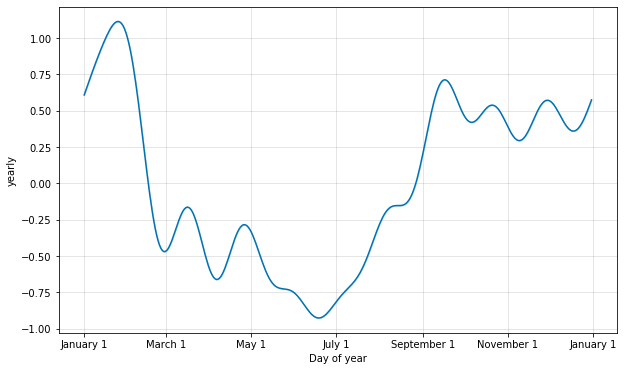

In [18]:
# using the default Fourier order for yearly seasonality - 10
from fbprophet.plot import plot_yearly
m = Prophet().fit(manning)
a = plot_yearly(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


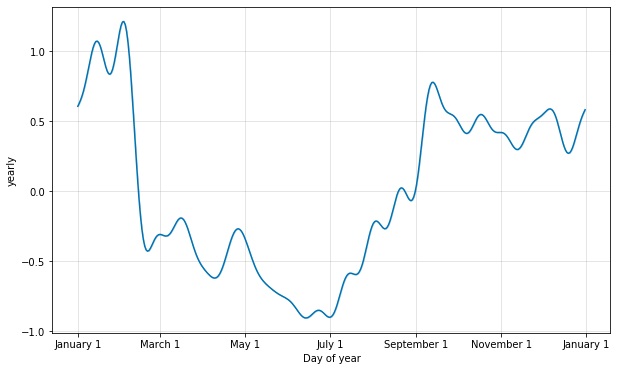

In [19]:
# increasing the Fourier order to 20
m = Prophet(yearly_seasonality=20).fit(manning)
a = plot_yearly(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


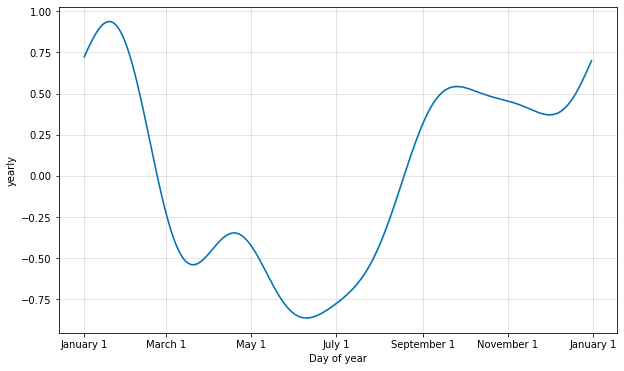

In [20]:
# decreasing the Fourier order to 5
m = Prophet(yearly_seasonality=5).fit(manning)
a = plot_yearly(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


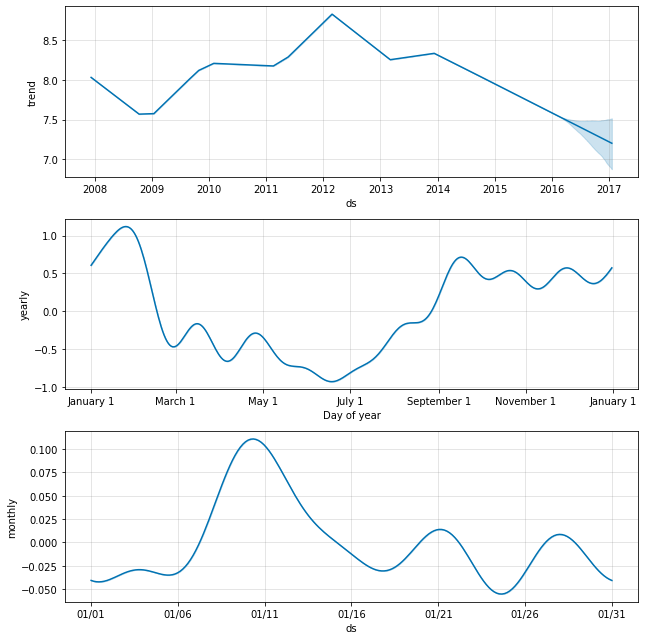

In [21]:
# Custom seasonality
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(manning).predict(manning_future)
fig = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


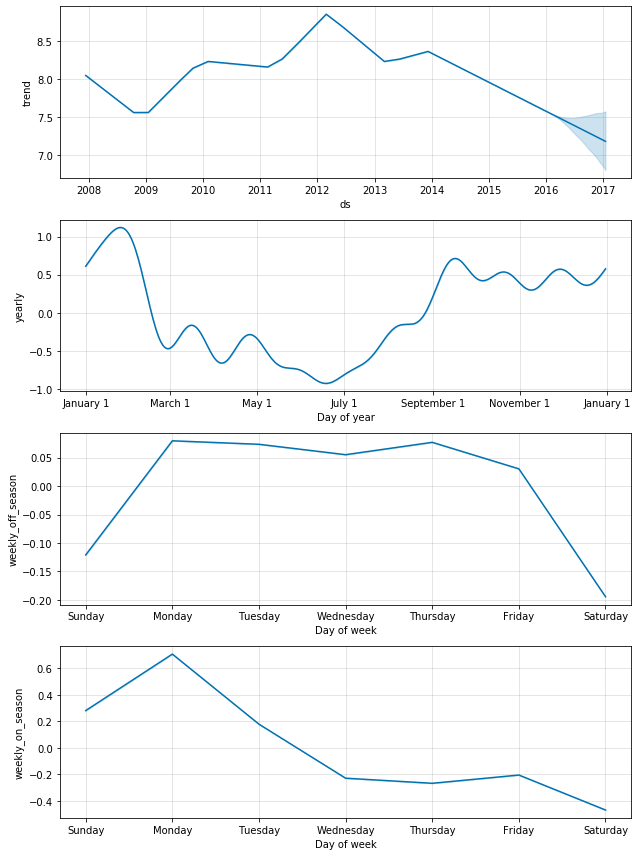

In [22]:
# Seaonality dependent on other factors - example from FB documentation
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

manning['on_season'] = manning['ds'].apply(is_nfl_season)
manning['off_season'] = ~manning['ds'].apply(is_nfl_season)

m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

manning_future['on_season'] = manning_future['ds'].apply(is_nfl_season)
manning_future['off_season'] = ~manning_future['ds'].apply(is_nfl_season)
forecast = m.fit(manning).predict(manning_future)
fig = m.plot_components(forecast)

### Multiplicative Seasonality

Prophet's default behavior uses an additive model for seasonal components. This does not work well if seasonality grows with the trend, as in the below example of monthly armed robberies in Boston.

Source for robberies data: https://github.com/jbrownlee/Datasets

In [23]:
# import robberies data in correct format
robberies = pd.read_csv('./data/monthly-robberies.csv', 
                        header=0, names=['ds','y'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


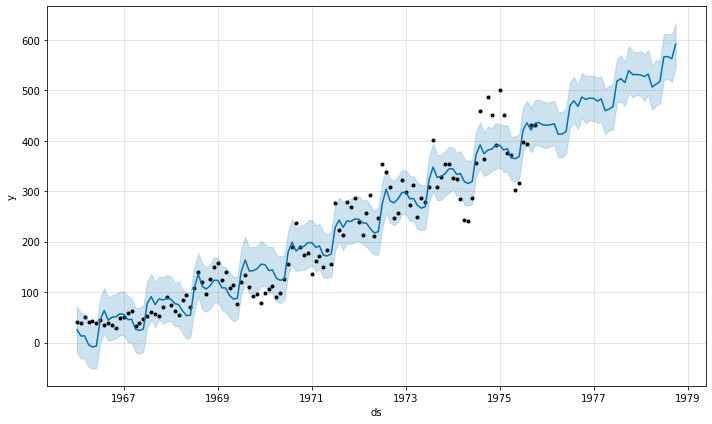

In [24]:
# Default setting - additive seasonality
m = Prophet()
m.fit(robberies)

future_robberies = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future_robberies) 

fig1 = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


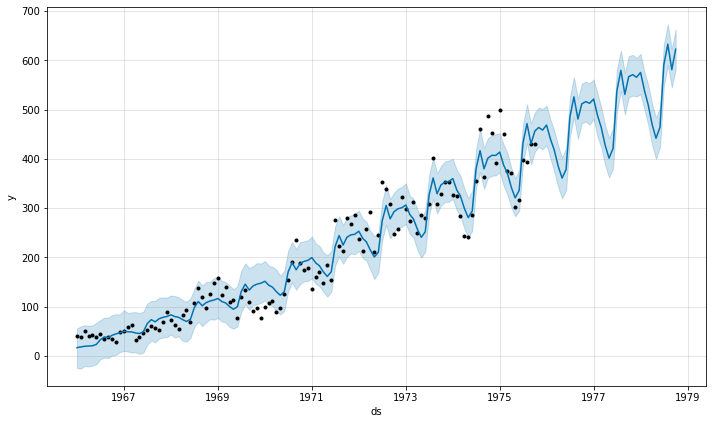

In [25]:
# Let's try with multiplicative seasonality
m = Prophet(seasonality_mode='multiplicative')
m.fit(robberies)

future_robberies = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future_robberies) 

fig1 = m.plot(forecast)

## Additional Regressors

In [26]:
# Find an example that highlights using additional regressors
# I do not have content for this at this time

## Outliers

As with many ML models, Prophet does not handle outliers well. The below example is meant to highlight how unstable predictions can become in time series with significant outliers. FB's Prophet documentation suggests dropping outliers to improve predictive power, but really it depends on the context. The below example is intentionally chosen as an example where removing outliers would be a TERRIBLE idea.

Source of VIX data: http://www.cboe.com/data/historical-options-data

In [27]:
# Dealing with outliers - VIX example
vix = pd.read_csv('./data/vix.csv',
                  usecols=[0,2], # Only looking at the 'High' of the day
                  skiprows=2015,
                  header=0, names=['ds','y']) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


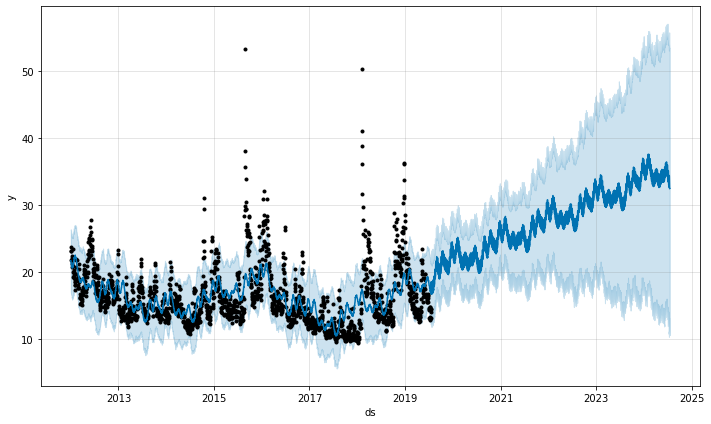

In [28]:
# Standard workflow
m = Prophet()
m.fit(vix)

# Making a very far out prediction to make a point...
future_vix = m.make_future_dataframe(periods=365*5)
forecast = m.predict(future_vix)

# Let's see how it went...
fig1 = m.plot(forecast)

## Diagnostics

In [29]:
# Wrap up with model diagnostics - I do not have content for this at this time

## Mathematical Details

Source material: [Prophet Paper](https://peerj.com/preprints/3190/)

### Trend

Nonlinear, Saturating Growth (basic model)
$$ {\large g(t) = \frac {C}{1 + e^{-k(t-m)}}} $$


where $C$ is the capacity (upper bound), $k$ is the growth rate, and $m$ is an offset parameter.

Adjustment at changepoint $j$
$$ \gamma_j = \Big(s_j - m - \sum_{l<j}\gamma_l\Big)\Big(1 - \frac{k + \sum_{l<j}\gamma_l}{k + \sum_{l\leq j}\gamma_l}\Big)$$

Linear Trend with Changepoints (no saturation point)
$$ g(t) = (k + \textbf{a}(t)^T \boldsymbol\delta)t + (m + \textbf{a}(t)^T \boldsymbol\gamma ) $$

___

### Seasonality

Seasonal component

$$ {\large s(t) = \textbf{X}(t)\boldsymbol\beta} $$

where $\textbf{X}(t)$ is a matrix of 2N seasonality vectors $\Big(cos\Big(\frac{2\pi nt}{P}\Big), sin\Big(\frac{2\pi nt}{P}\Big)\Big)$ for each value of $t$ in the past and future, and $\boldsymbol\beta$ is the vector of 2N parameters ($a_n, b_n)  \forall n \in N$, based on a standard Fourier series

$$ s(t) = \sum_{n=1}^{N}\Big(a_ncos\Big(\frac{2\pi nt}{P}\Big) + b_nsin\Big(\frac{2\pi nt}{P}\Big)\Big) $$

___

### Holidays and Events

Specify a vector of pre-defined holidays and events.

$$ {\large h(t) = Z(t)\kappa} $$

where $Z(t) = [\textbf1(t\in D_1),...,\textbf1(t\in D_L)]$ is a matrix of holiday regressors.


## Conclusions

#### Benefits

* Greater flexibility and control over modeling
* User can think in terms of domain knowledge rather than abstract math
* More accessible than standard time series models
* Since it models everything, including the past, it can handle missing data

#### Drawbacks

* Need subject matter expertise to get full value
* No guarantee it will be maintained and well supported
* Other models may end up performing better with less need for analyst control
* Uses date as an 'object' column rather than a datetime index, so you can't to just 'plug and play' your data as with other TS models. You can work around this.
* Not a 'silver bullet' - you still have to think!

## Resources

* [Documentation](https://facebook.github.io/prophet/)
* [Working Paper](https://peerj.com/preprints/3190/)

### Blog Posts
* [Implementing Facebook Prophet Efficiently](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)
* [Forecasting with Prophet](https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91)
* [Stock Market Cycles](https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0)